In [1]:
import dns.query, dns.message, dns.rdatatype, dns.rdataclass
from dns.rdatatype import AAAA, A, DNSKEY, TXT, CNAME, SOA, MX, DS, RRSIG, DS, NS, PTR, SRV, ANY, A6, KEY
from dns.rdataclass import IN

In [2]:
ALGORITHMS = {
    5: "rsasha1", 8: "rsasha256", 10: "rsasha512",  # pdns also supports 7: "rsasha1-nsec3-sha1",
    13: "ecdsa256", 14: "ecdsa384",
    15: "ed25519", 16: "ed448",
    17: "falcon",
}
ALGORITHM_COLORS = {
    "rsasha1": "#ff0000", "rsasha256": "#dd0000", "rsasha512": "#bb0000",
    "ecdsa256": "#00ff00", "ecdsa384": "#00dd00",
    "ed25519": "#0000ff", "ed448": "#0000dd",
    "falcon": "#00ffff",
}

In [3]:
scenarios = {
    'SOA with RRSIG': (SOA, lambda a: f'{a}.example.'),
    '1 AAAA RR with RRSIG for Wildcard (NSEC)': (AAAA, lambda a: f'wildcard.{a}.example.'),
    '1 AAAA RR with RRSIG for Wildcard (NSEC3)': (AAAA, lambda a: f'wildcard.{a}3.example.'),
    'NSEC Proof of NX': (TXT, lambda a: f'nx.{a}.example.'),
    'NSEC3 Proof of NX': (TXT, lambda a: f'nx.{a}3.example.'),
    #'ANY': (ANY, lambda a: f'{a}.example.'),

    '2 A RRs with RRSIG': (A, lambda a: f'{a}.example.'),
    'NS': (NS, lambda a: f'{a}.example.'),
    '1 AAAA RR with RRSIG': (AAAA, lambda a: f'{a}.example.'),
    '1 DNSKEY with RRSIG': (DNSKEY, lambda a: f'{a}.example.'),
    #'CNAME': (CNAME, lambda a: f'nx.{a}example.'),
    'MX': (MX, lambda a: f'{a}.example.'),
    #'DS': (DS, lambda a: f'{a}.example.'),
    'TXT': (TXT, lambda a: f'{a}.example.'),
    'PTR': (PTR, lambda a: f'{a}.example.'),
    'SRV': (SRV, lambda a: f'{a}.example.'),
    #'A6': (A6, lambda a: f'{a}.example.'),
    'KEY': (KEY, lambda a: f'{a}.example.'),
}

In [4]:
raw_data = []
for scenario, (rtype, name) in scenarios.items():
    for a in ALGORITHMS.values():
        for s in ["initial-", "new_rrsig-", "new_dnskey-", "dnskey_removal-", "rrsig_removal-"]:
            
            qname = dns.name.from_text(name(s+a))
            r = dns.query.tcp(dns.message.make_query(qname, rtype, want_dnssec=True), where='127.0.0.1', port=5301)
            rwire = r.to_wire()
            raw_data.append({
                'step': s,
                'scenario': scenario,
                'algorithm': a,
                'length': len(rwire),
                'qname_count': [rwire.count(qname.split(i)[1].to_wire()) for i in range(len(qname), 1, -1)],
                'qname': qname.to_text(),
            })

In [5]:
import pandas as pd

In [6]:
data = pd.DataFrame(raw_data)
data.to_csv('full_data.csv')
data.sample(20)
data.to_csv('sampled_data.csv')

In [7]:
import seaborn as sns

sns.set(font_scale=2)
sns.set_style('whitegrid')

In [8]:
ALGORITHM_ORDER = list(ALGORITHM_COLORS.keys())
ALGORITHM_PALETTE = sns.color_palette([ALGORITHM_COLORS[a] for a in ALGORITHM_ORDER])

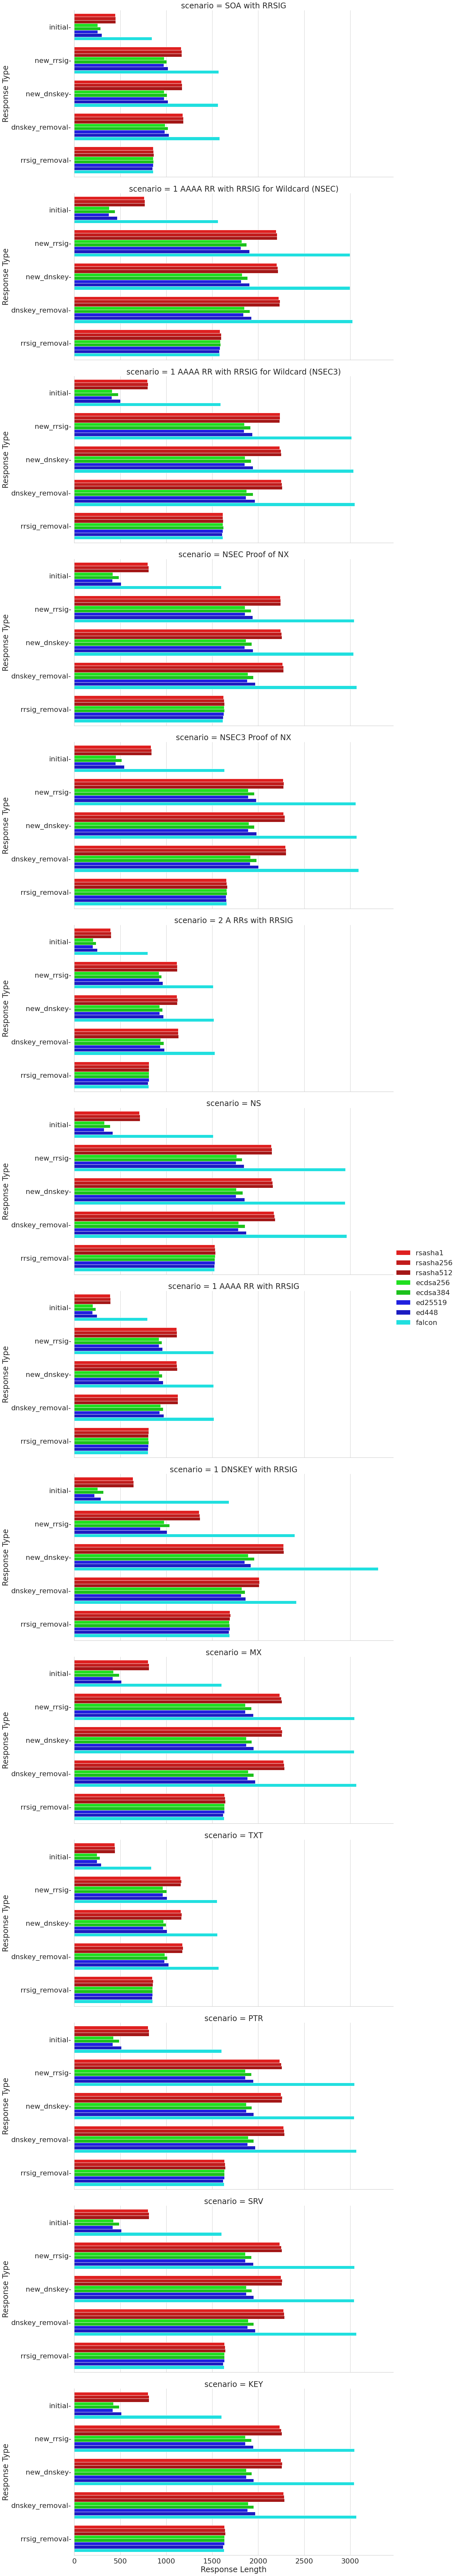

In [9]:
g = sns.catplot(
    data=data,
    row='scenario',
    y='step',
    #y = 'scenario',
    hue='algorithm', hue_order=ALGORITHM_ORDER, palette=ALGORITHM_PALETTE,
    x='length',
    kind='bar',
    height=8,
    aspect=18/8,
)
g.set(
    ylabel='Response Type',
    xlabel='Response Length',
)
g.legend.set_title('')
g.savefig('nils3.pdf')

KEY


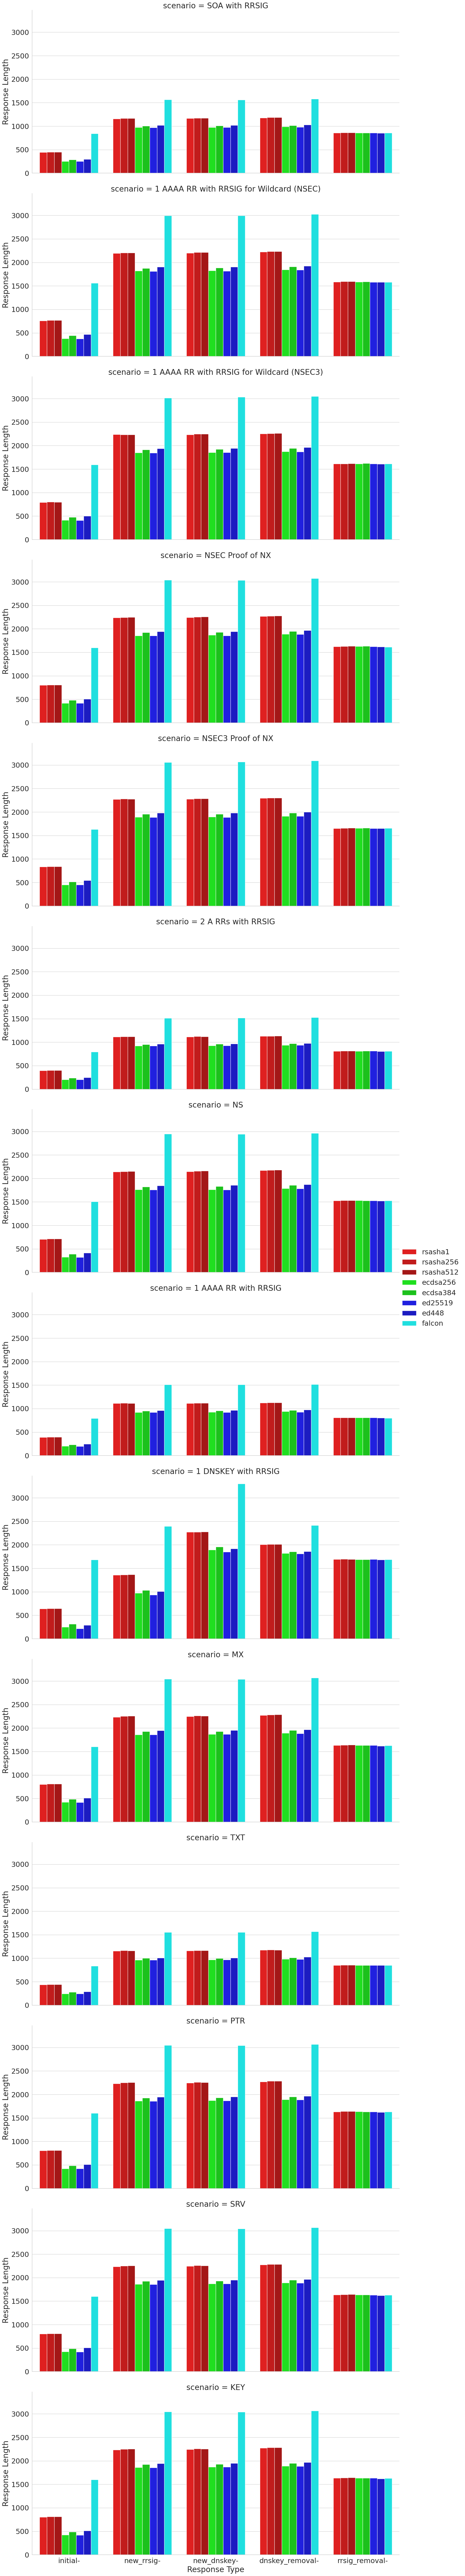

In [11]:
# han's generated output

# print(ALGORITHM_ORDER)
# print(ALGORITHM_PALETTE)

print(scenario)
g = sns.catplot(
    data=data,
    row='scenario',
    x = 'step',
    y = 'length',
    hue='algorithm', hue_order=ALGORITHM_ORDER, palette=ALGORITHM_PALETTE,
    kind="bar",
    height=8,
    aspect=18/8,
    
)
g.set(
    ylabel='Response Length',
    xlabel='Response Type',
)

g.legend.set_title('')
g.savefig('han1.pdf')